<figure>
<img src='https://cdn.wccftech.com/wp-content/uploads/2021/07/Spotify.jpg'">
</figure>

In [32]:
%%html
<marquee style='width: 50%; color: green;font-size:50px'><b>Analyze Song on Spotify!</b></marquee>

# Index

- ### <a href='#q1'>Question 1: Show which song has longest duration? What is the insight of this?</a>
- ### <a href='#q2'>Question 2: - Plot line graph for number of tracks over release years, what can you infer from this graph? - Plot line graph for tracks with duration over release years, what can you infer from this graph??</a>
- ### <a href='#q3'>Question 3: Song trend over time from 1920 to 2020?</a>
- ### <a href='#q4'>Question 4: Who are the most famous artists at this time in 1955-1960??</a>
- ### <a href='#q5'>Question 5: Which actual top artists write/have the most popular songs?</a>
- ### <a href='#q5'>Question 6: Compare music 1990s before and after?</a>
- ### <a href='#q5'>Question 7: How do you become a famous song writer??</a>
- ### <a href='#q5'>Question 8: Which actual top artists write/have the most popular songs?</a>
- ### <a href='#q5'>Question 9: In order to write a popular song, is the key and mode important? Does popularity depend on the categorical values of key and/or mode?</a>
- ### <a href='#q5'>Question 10: Recommend Song for user when input artist, songs?</a>

# About Spotify
Spotify is a Swedish audio streaming and media services provider founded in 2006 by Daniel Ek. It is one of the world's largest music streaming service providers.

There is 2 datasets use in this note, the 1st dataset use for question from (1 to 9) and the 2nd dataset is use for question 10.
This 1st dataset (Spotify_Song_1921_2020) has 170653 observations, 19 columns (13 numerical and 6 categorical/dummy).

- **numerical** columns: 
    - acousticness: The relative metric of the track being acoustic, (Ranges from 0 to 1)
    - danceability: The relative measurement of the track being danceable, (Ranges from 0 to 1)
    - energy: The energy of the track,  (Ranges from 0 to 1)
    - duration_ms: The length of the track in milliseconds (ms), (Integer typically ranging from 200k to 300k)
    - instrumentalness:, The relative ratio of the track being instrumental, (Ranges from 0 to 1)
    - valence: The positiveness of the track, (Ranges from 0 to 1)
    - popularity: The popularity of the song lately, default country = US, (Ranges from 0 to 100)
    - tempo:The tempo of the track in Beat Per Minute (BPM), (Float typically ranging from 50 to 150)
    - liveness: The relative duration of the track sounding as a live performance, (Ranges from 0 to 1)
    - loudness: Relative loudness of the track in decibel (dB), (Float typically ranging from -60 to 0)
    - speechiness: The relative length of the track containing any kind of human voice, (Ranges from 0 to 1)
    - year: The release year of track, (Ranges from 1921 to 2020)
    - id, The primary identifier for the track, generated by Spotify
    
- **categorical** columns:
    - key: The primary key of the track encoded as integers in between 0 and 11 (starting on C as 0, C# as 1 and so on…)
    - artists: The list of artists credited for production of the track 
    - release_date: Date of release mostly in yyyy-mm-dd format, however precision of date may vary
    - name: The title of the track 
    - mode: The binary value representing whether the track starts with a major (1) chord progression or a minor (0)
    - explicit: The binary value whether the track contains explicit content or not, (0 = No explicit content, 1 = Explicit content)

In [33]:
#import library
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
# SKLEARN - ML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

# define class and function

In [34]:
class ArtistsTransformer():
  def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
      self.MinCnt = MinCnt
      self.MaxCnt = MaxCnt
      self.artists_df = None
  
  def fit (self, X, y):
      self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
      self.artists_df.loc['unknown'] = [y.mean(), 1]
      self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
      self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
      return self

  def transform(self, X, y=None):
      X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
      X['artists'] = X['artists'].map(self.artists_df['mean'])
      return X

In [35]:
def year_range(df, period): 
    #for define year range
    period_track_count = {}
    df_ranged = df[(df['year'] >= period[0]) & (df['year'] <= period[1])]
    period_track_count[str(period[0]) + '-' + str(period[1])] = df_ranged.shape[0]
    
    return df_ranged, period_track_count


In [36]:
def get_prepared_df(df, cols_to_drop, target):
    col_drop_with_target = cols_to_drop.copy()
    col_drop_with_target.append(target)
    
    # list with dependent and independent variables
    xy_columns = df.drop(cols_to_drop, axis=1).columns.tolist()
    printmd('#### Dependent and independent variable set')
    print(xy_columns)
    
    # list with only independent variables
    x_columns = df.drop(col_drop_with_target, axis=1).columns.tolist()
    printmd('#### Only independent variables')
    print(x_columns)   
    
    # data_cleaned = df with cols_to_drop removed
    data_cleaned = df.drop(cols_to_drop, axis=1)
    
    # Remove zero tempo (zero danceability and zero speechiness) rows
    data_cleaned = data_cleaned[data_cleaned['tempo'] !=0]
    printmd('#### New shape of prepared DataFrame')
    print(data_cleaned.shape)
    column_set = data_cleaned.columns.tolist()
    return data_cleaned, xy_columns, x_columns

In [37]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    
    df  = df.dropna(subset=[response_col], axis=0)
    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)
    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    # Apply AritistsTransformer on train and test seperatly
    artists_transformer = ArtistsTransformer(MinCnt=2)
    X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
    X_test = artists_transformer.transform(X_test, y_test)
    
    scaler = MinMaxScaler()
    cols = X.columns.tolist()
    X_train[cols] = scaler.fit_transform(X_train[cols])
    X_test[cols] = scaler.fit_transform(X_test[cols])

    lm_model = LinearRegression(normalize=False) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds

In [38]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [39]:
def find_song_database(name, artist, songs):
    result = songs[(songs.artist_name == str(artist)) & (songs.track_name == str(name))]
    if len(result) == 0:
        return None
    return result.drop(['track_name', 'artist_name', 'Cluster'], axis = 1)

def find_similar(name, artist, songs, top_n = 5):
    database = songs[songs.popularity > 0.5].reset_index(drop = True)
    indx_names = database[['track_name', 'artist_name', 'Cluster']]
    songs_train = database.drop(['track_name', 'artist_name', 'Cluster'], axis = 1)

    song = find_song_database(str(name), str(artist), database)
    
    if type(song) != type(None):
        indx_song = song.index

        cos_dists = cosine_similarity(songs_train, songs_train)
        indx_names.loc[:,['result']] = cos_dists[indx_song[0]]

        indx_names = indx_names.sort_values(by = ['result'], ascending = False)

        return indx_names[1:top_n].reset_index(drop = True)
    
    else:
        print("Song not found")
        return None
    
    
def playlist_song(name, artist, songs, n_songs = 10):
    list_songs = find_similar(str(name), str(artist), songs, n_songs)
    
    if type(list_songs) != type(None):
    
        print('Playlist based on "' + str(name) + '" by ' + str(artist))
        print()

        for i in np.arange(0,len(list_songs)):
            track_name = list_songs.track_name[i]
            artist_name = list_songs.artist_name[i]

            print(str(track_name) + ' - ' + str(artist_name))
            
    return None

In [40]:
def plot_barh(df, value, title, y_label,color_bar,color_y,color_title,display_value: bool, **kwargs):
    #use for plot horizontal chart
    y_pos = df.index
    people = df[value]

    fig, ax = plt.subplots()
    ax.barh(y_pos, people, align='center',color = color_bar)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_pos,color = color_y)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(y_label)
    ax.set_title(title,color = color_title)
    if display_value == True:
        for index, value in enumerate(people):
            plt.text(value, index, str(round(value,2)),color = 'green')
    # Add Text watermark
    fig.text(0.2, 0.02, 'Nguyễn Long', fontsize=12,
            color='green', ha='right', va='bottom',
            alpha=0.4)
    fig.patch.set_facecolor('white')
    plt.show()

In [41]:
def plot_bar(height, x, color,fig_dims, title, color_title, x_rotate, **kwargs):
    #use for plot vertical chart
    font = {'family':'serif','color': color_title,'size':18}
    fig, ax = plt.subplots(figsize = fig_dims)
    sns.set_style(style="darkgrid")
    ax.bar(height = height,x = x, color = color)
    ax.set_title(title,color = color_title,fontdict=font)
    plt.xticks(rotation=90,fontsize = 15)
    fig.text(x = 0.9, y = 0.15, s = 'Nguyễn Long', fontsize=12,
            color='green', ha='right', va='bottom',
            alpha=0.7)
    plt.show()

In [42]:
#read 1st dataset 
df=pd.read_csv("Spotify_Song_1921_2020.csv")
df.head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [43]:
# prepare the dataframe for model creation. Start from the prepared numerical dataframe
df_for_ml, _ = year_range(df, [1921,2020]) 
df_for_ml, xy_columns, x_columns = get_prepared_df(df_for_ml, ['id', 'name', 'release_date', 'year'], 'popularity')

print(df_for_ml.shape)

response_col = 'popularity'
cat_cols_lst = ['key', 'mode', 'explicit']

#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_test_preds = clean_fit_linear_mod(df_for_ml, response_col, cat_cols_lst, dummy_na=False)

#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

#### Dependent and independent variable set

['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence']


#### Only independent variables

['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']


#### New shape of prepared DataFrame

(169762, 15)
(169762, 15)
The rsquared on the training data was 0.6713177339320056.  The rsquared on the test data was 0.6339927468143611.


In [44]:
# Get cleaned DataFrame with only numerical columns including the target column
data_cleaned, xy_columns, x_columns = get_prepared_df(df, ['id', 
                                                       'name', 
                                                       'release_date', 
                                                      ],
                                                       'popularity')

#### Dependent and independent variable set

['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo', 'valence', 'year']


#### Only independent variables

['acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year']


#### New shape of prepared DataFrame

(169762, 16)


In [45]:
df.info()
printmd("there is no null value in this dataset, so no need to fill null or remove null value")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

there is no null value in this dataset, so no need to fill null or remove null value

In [46]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,169909.0,0.493214,0.376627,0.0,0.0945,0.492000,0.8880,0.996
danceability,169909.0,0.538150,0.175346,0.0,0.4170,0.548000,0.6670,0.988
duration_ms,169909.0,231406.158973,121321.923219,5108.0,171040.0000,208600.000000,262960.0000,5403500.000
energy,169909.0,0.488593,0.267390,0.0,0.2630,0.481000,0.7100,1.000
explicit,169909.0,0.084863,0.278679,0.0,0.0000,0.000000,0.0000,1.000
instrumentalness,169909.0,0.161937,0.309329,0.0,0.0000,0.000204,0.0868,1.000
key,169909.0,5.200519,3.515257,0.0,2.0000,5.000000,8.0000,11.000
liveness,169909.0,0.206690,0.176796,0.0,0.0984,0.135000,0.2630,1.000
loudness,169909.0,-11.370289,5.666765,-60.0,-14.4700,-10.474000,-7.1180,3.855
mode,169909.0,0.708556,0.454429,0.0,0.0000,1.000000,1.0000,1.000


[Text(0.5, 0, 'acousticness'),
 Text(1.5, 0, 'danceability'),
 Text(2.5, 0, 'duration_ms'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'instrumentalness'),
 Text(5.5, 0, 'liveness'),
 Text(6.5, 0, 'loudness'),
 Text(7.5, 0, 'popularity'),
 Text(8.5, 0, 'speechiness'),
 Text(9.5, 0, 'tempo'),
 Text(10.5, 0, 'valence')]

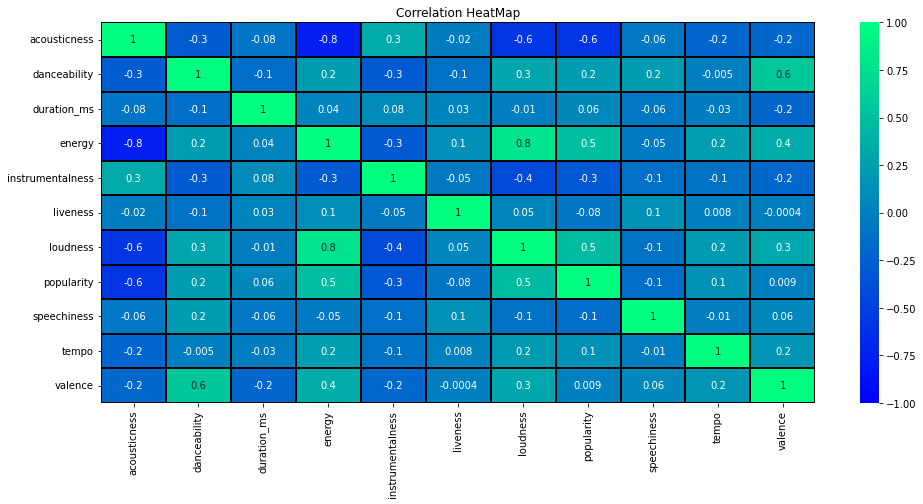

In [47]:
#correlation, must drop column : key, mode , year, explicit
corr_df=df.drop(["key","mode","year","explicit"],axis=1).corr(method="pearson")
plt.figure(figsize=(16,7))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g", vmin=-1, vmax=1, center=0, cmap="winter", linewidths=1, linecolor="Black")
heatmap.set_title("Correlation HeatMap")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

From the correlation heat map, we can observe that **acoustic** seems to have a strong negative correlance with **energy** **(-0.8)** and strong negative correlances with **loudness** and **popularity** (-0,6).

**Energy** and **loudness** have a strong positive correlance (0,8), while positive correlances are present between **loudness** and **popularity** and **danceability** and **valence**.

Add another column "duration by seconds", the dataset only have duration by miliseconds, not easy to check the data 

In [48]:
df["duration"]= df["duration_ms"].apply(lambda x: round(x/1000))
df.drop("duration_ms", inplace=True, axis=1)
df_data = df.copy()
df.duration.head()

0    159
1    282
2    104
3    181
4    688
Name: duration, dtype: int64

# **Question 1**: 
# Show which song has longest duration? What is the insight of this

In [85]:
df[df["duration"]==df["duration"].max()].iloc[0]

acousticness                           0.111
artists                    ['Sound Dreamer']
danceability                             0.0
energy                              0.000099
explicit                                   0
id                    7foc25ig7dibxvULPU2kBG
instrumentalness                       0.392
key                                        2
liveness                               0.137
loudness                             -21.669
mode                                       1
name                Brown Noise - 90 Minutes
popularity                                50
speechiness                              0.0
tempo                                    0.0
valence                                  0.0
year                                    2013
duration                                5404
dates                    2013-06-05 00:00:00
Name: 2013-06-05, dtype: object

The track called Brown noise - 90 minutes is the track with the longest duration in the database (**5404 seconds ~ 90 mintues long**). In science, Brownian noise, also known as Brown noise or red noise, is the kind of signal noise produced by Brownian motion, hence its alternative name of random walk noise.

Most people listen to thos noise on loop for relaxation purposes, to fall asleep or meditation. Thus it is no surprise that brown noise is the longest track on this dataset.

# **Question 2**: 
# - Plot line graph for number of tracks over release years, what can you infer from this graph?
# - Plot line graph for tracks with duration over release years, what can you infer from this graph?

In [50]:
# get year column
df.set_index("release_date", inplace=True)
df['dates']=df.index.get_level_values('release_date')
df.dates=pd.to_datetime(df.dates)
years=df.dates.dt.year

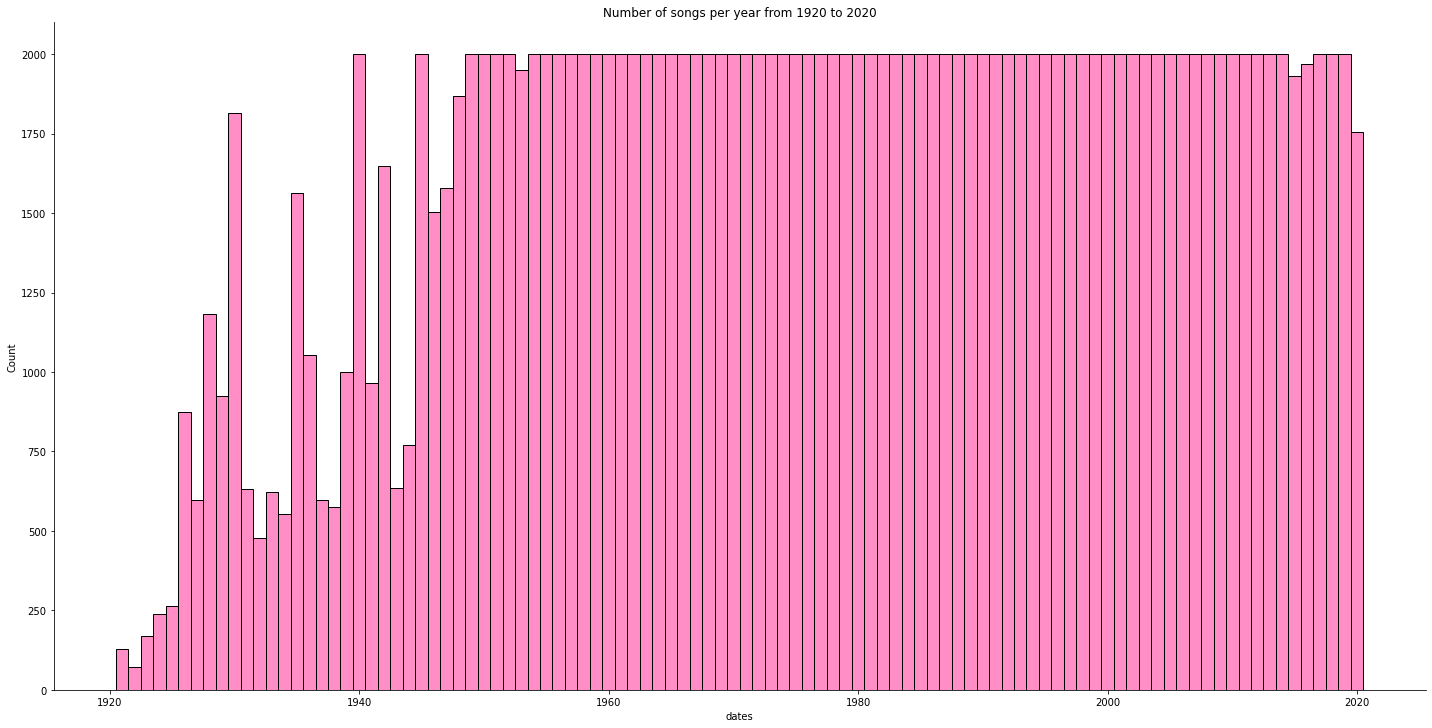

In [51]:
sns.displot(years,discrete=True,aspect=2,height=10 ,kind="hist",color='hotpink').set(title="Number of songs per year from 1920 to 2020")

As may seen from above, there was a tendency for track around 2000 for track has release date from 1940 until 2019 (this dataset may be not update completely in 2020, because the latest release date is 2020-06-18, may be in 2020 in full also 2000 tracks)
So, we can assume that Spotify choose 2000 tracks for every year, before 1940, Spofity have not enough songs, may be they can't find the records of tracks for this period (too expensive or too difficult to find)

In [52]:
# get the duration and year for plot graph
dur = df['duration'].groupby(by = df.index).mean()
year = df['year'].groupby(by = df.index).mean()
dur

release_date
1921          245.105263
1921-02-20    202.500000
1921-03-20    165.190476
1921-03-27    205.000000
1921-04-12    182.000000
                 ...    
2020-06-12    220.600000
2020-06-15    186.000000
2020-06-16    222.750000
2020-06-17    178.000000
2020-06-18    232.000000
Name: duration, Length: 10882, dtype: float64

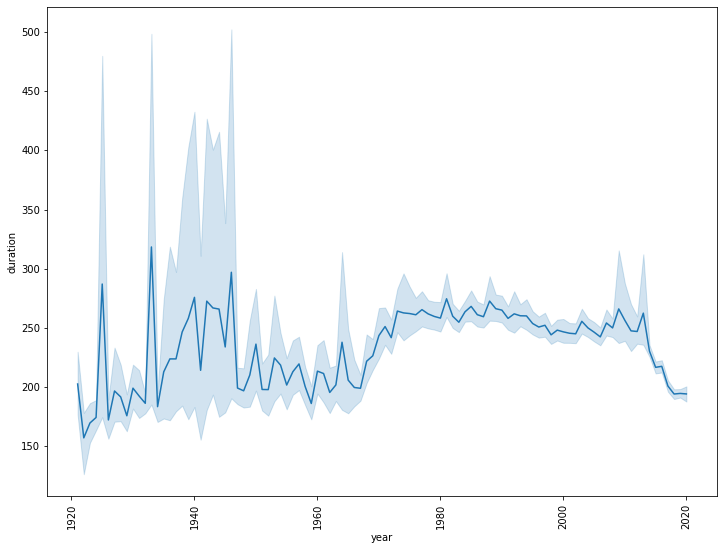

In [53]:
#Plot line graph for tracks with duration over release years
fig_dims = (12, 9)
fig, ax = plt.subplots(figsize=fig_dims)
data_plot = pd.DataFrame({"year":year, "duration":dur})
fig = sns.lineplot(x = "year", y = "duration", data=data_plot)
plt.xticks(rotation=90)
plt.show()

Given above is the line plot for the average duration of songs over the years. As we can see, the songs from 1920s to 1960s have comparatively shorter durations since most of the songs tended to be more singing based rather than instrument based. 
However, the trend changed in the 60s and 70s when this time had Hard Rock and Metal that popped up with amazing instrumental parts and resulted is the increasing the duration of the songs.This trend continued up until the 2010s. 
In the present day, the duration of songs is declining again since the attention span of the average listener is also declining. This can be attributed from that music available on the internet. So the artists of today has a very small apan to leave an impact on the listener and thus has to shorten his song duration.

# **Question 3**: 
# Song trend over time from 1920 to 2020

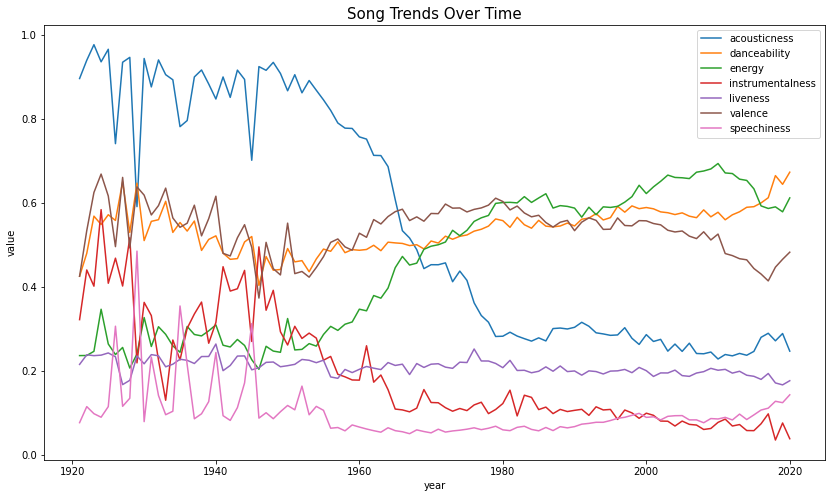

In [54]:
year_avg = df[["acousticness","danceability","energy", "instrumentalness", 
               "liveness","tempo", "valence", "loudness", "speechiness", "year"]].\
groupby("year").mean().sort_values(by="year").reset_index()

# year_avg.head()
plt.figure(figsize=(14,8))
plt.title("Song Trends Over Time", fontdict={"fontsize": 15})

lines = ["acousticness","danceability","energy", 
         "instrumentalness", "liveness", "valence", "speechiness"]

for line in lines:
    ax = sns.lineplot(x='year', y=line, data=year_avg)
    
    
plt.ylabel("value")
plt.legend(lines)

- As can be seen, index of Accousticness used to be very high and suddenly fluctuated slump to from 1..0 to 0.2 in 2020. This proved that from 1920 to 1950,  there were many top hits that have instrument of piano and violen was published. But up to now, there have not too much with the rising of electric instruments.
- Whereas, the index of Danceability and Energy had tend to soaring with nearly 0.7. So, we can assume that man has tend to launch upbeat song (more tempo and more vibrant song) 
- The lowest index is Speechiness, there was many change from 1920 to 1950 but always low at range from 0.1 to 0.2.
Speechiness represent for products of track of story tellings, verbal books, verbal poems available on Spotify but very few comparte to songs


# **Question 4**: 
# Who are the most famous artists at this time in 1955-1960?

**Why is 1955 - 1960?**
- A low noise trend can be observed for the popularity-dependence on year.
- It is obvious that popularity increases with years. We will see how is their relationship on the below.
- And, there is an abrupt increase of popularity around the mid/end of the fifties of the last century.

(-10.0, 80.0)

<Figure size 216x216 with 0 Axes>

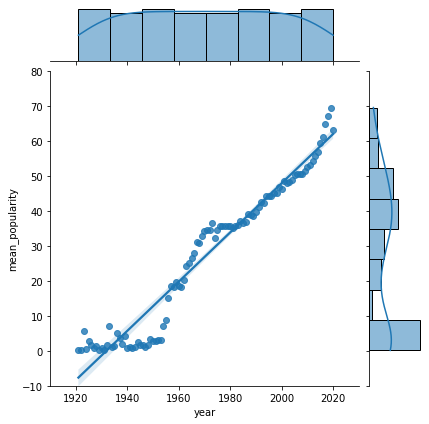

In [55]:
# Create scatter plot with density plots for the axis
plt.figure(figsize=(3,3))
mean_df = df.groupby(['year'])['popularity'].mean().to_frame().reset_index()
mean_df['mean_popularity'] = mean_df['popularity']
mean_df_55_60 = mean_df[(mean_df['year']>1954) & (mean_df['year']<1960)]

plot = sns.jointplot(x='year', y='mean_popularity', data=mean_df, kind='reg')
plot.ax_marg_x.set_xlim(1910, 2030)
plot.ax_marg_y.set_ylim(-10, 80)

by comparing mean popularity by years, we can see the mean popularity is increased linearly from 1920 to 2020.

This mean the artist and tracks are more **well-known** in the present than in the past.

In [86]:
# Find the most popular top 10 artists between 1950 and 1960
# As a second order popularity condition, artists must have more than 100 songs on Spotify
data_late50s_topArtists = df[(df['year'] > 1955) & (df['year'] < 1960)].sort_values(by='popularity', ascending=False)
printmd('***1955-1960 most popular songs:***')
data_late50s_topArtists.loc[:,'artist'] = data_late50s_topArtists['artists'].map(lambda x: x.replace('[', '').replace(']', '').replace('\'', ''))

display(data_late50s_topArtists[['name', 'artist', 'popularity', 'year']].head(10))

data_late50s_topArtists['top_artist'] = data_late50s_topArtists['artists'].map(df['artists'].value_counts()>100)
pop_arts  = data_late50s_topArtists.groupby(['artist', 'top_artist'])['popularity'].mean().sort_values(ascending=False).reset_index(1)
data_to_plot = pop_arts.loc[pop_arts['top_artist'] == True,['popularity']].head(10)

***1955-1960 most popular songs:***

,name,artist,popularity,year
release_date,,,,
1959-07-01,Johnny B. Goode,Chuck Berry,74,1959
1958-03-21,Jailhouse Rock,Elvis Presley,73,1958
1957-01-01,Dream A Little Dream Of Me - Single Version,"Ella Fitzgerald, Louis Armstrong",71,1957
1958-03-21,Hound Dog,Elvis Presley,69,1958
1958,Come Fly With Me - Remastered,Frank Sinatra,69,1958
1956-03,I've Got You Under My Skin - Remastered 1998,Frank Sinatra,67,1956
1958-06-24,My Baby Just Cares for Me - 2013 Remastered Ve...,Nina Simone,67,1958
1957-01-01,I've Got a Woman,Ray Charles,67,1957
1959,Big Iron,Marty Robbins,67,1959


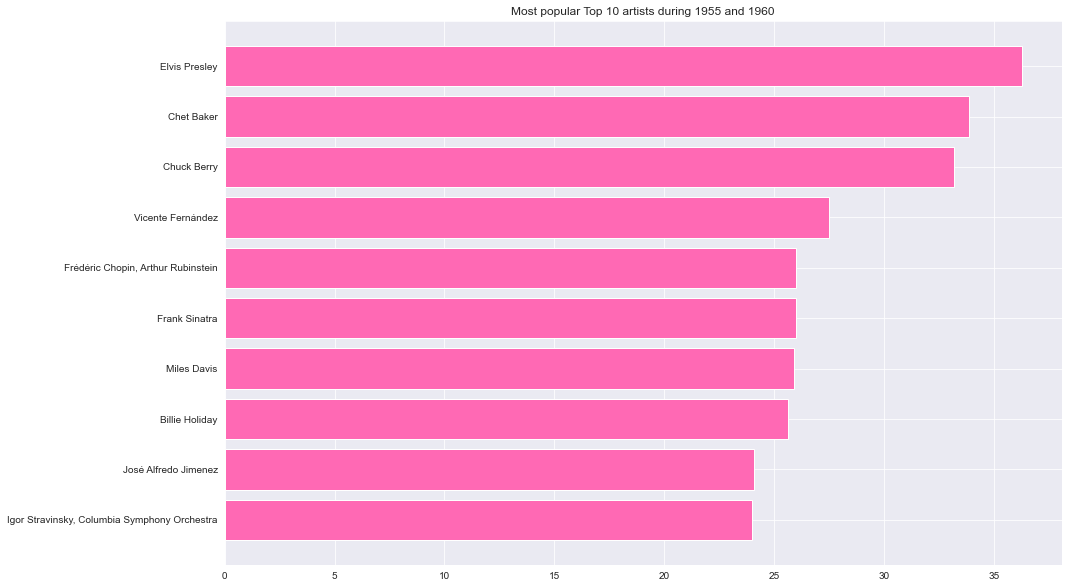

In [93]:
fig, ax = plt.subplots(figsize = fig_dims)
ax.barh(y_pos, people, align='center',color = 'hotpink')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('')
ax.set_title('Most popular Top 10 artists during 1955 and 1960')
plt.show()

### Conclusion abut the results:
Of course, this no surprise for music experts. The top winners were: Elvis Presley, Chet Baker, Chuck Berry and Frank Sinatra. Maybe nobody would know them today, although they were all fantastic musicians.

# **Question 5**: 
# Which actual top artists write/have the most popular songs?


In [58]:
# Who are the top 10 artists between 1921-2020?
# As a second order popularity condition, artists must have more than 250 songs on Spotify
data_topArtists = df.sort_values(by='popularity', ascending=False)
printmd('***Most popular songs:***')
data_topArtists.loc[:,'artist'] = data_topArtists['artists'].map(lambda x: x.replace('[', '').replace(']', '').replace('\'', ''))

display(data_topArtists[['name', 'artist', 'popularity', 'year']].head(10))

data_topArtists['top_artist'] = data_topArtists['artists'].map(data_topArtists['artists'].value_counts()>250)
top_art  = data_topArtists.groupby(['artist', 'top_artist'])['popularity'].mean().sort_values(ascending=False).reset_index(1)
data_to_plot = top_art.loc[top_art['top_artist'] == True,['popularity']].head(20)

***Most popular songs:***

,name,artist,popularity,year
release_date,,,,
2020-03-20,Blinding Lights,The Weeknd,100,2020
2020-04-17,ROCKSTAR (feat. Roddy Ricch),"DaBaby, Roddy Ricch",99,2020
2020-02-08,death bed (coffee for your head) (feat. beabad...,"Powfu, beabadoobee",97,2020
2020-04-24,THE SCOTTS,"THE SCOTTS, Travis Scott, Kid Cudi",96,2020
2019-11-26,ily (i love you baby) (feat. Emilee),"Surf Mesa, Emilee",95,2019
2020-04-03,Toosie Slide,Drake,95,2020
2019-12-06,The Box,Roddy Ricch,95,2019
2019-11-15,Supalonely,"BENEE, Gus Dapperton",95,2019
2020-04-21,Party Girl,StaySolidRocky,94,2020


*artists with more than 200 songs on Spotify

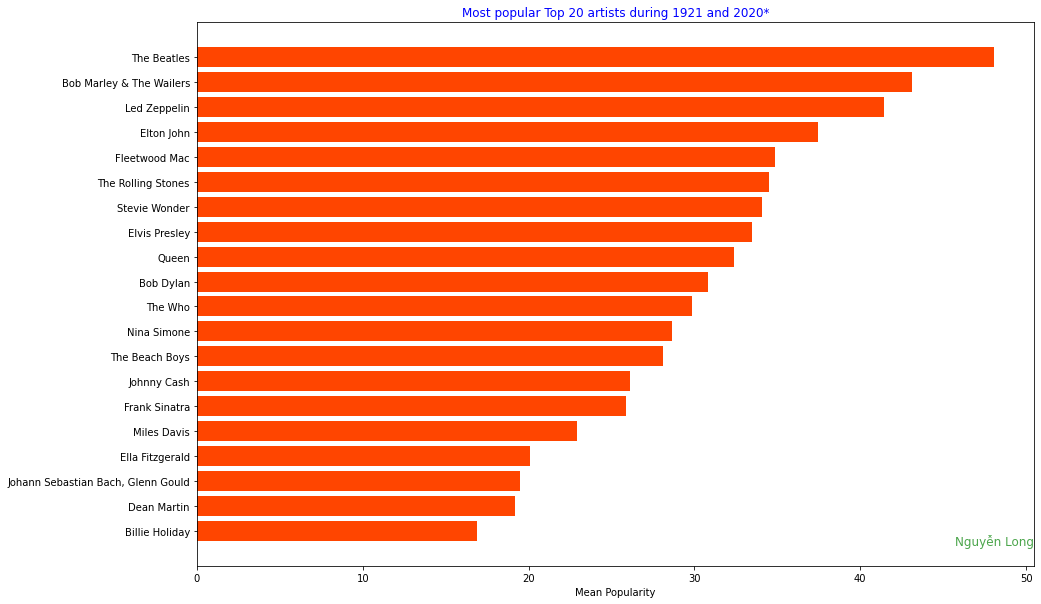

In [59]:
printmd('*artists with more than 200 songs on Spotify')
plot_barh(data_to_plot,)
y_pos = data_to_plot.index
people = data_to_plot['popularity']

fig_dims = (15,10)
fig, ax = plt.subplots(figsize = fig_dims)
ax.barh(y_pos, people, align='center',color = 'orangered')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Popularity')
ax.set_title('Most popular Top 20 artists during 1921 and 2020*',color = 'blue')
# Add Text watermark
fig.text(x = 0.9, y = 0.15, s = 'Nguyễn Long', fontsize=12,
         color='green', ha='right', va='bottom',
         alpha=0.7)
plt.show()

as seen from the above is the top 20 artist during 1920 to 2020 by mean of popularity.

# **Question 6**: 
# Compare music 1990s before and after

In [60]:
df_pre90 = df_data[df_data.year <= 1990]
df_post_90 = df_data[df_data.year > 1900]

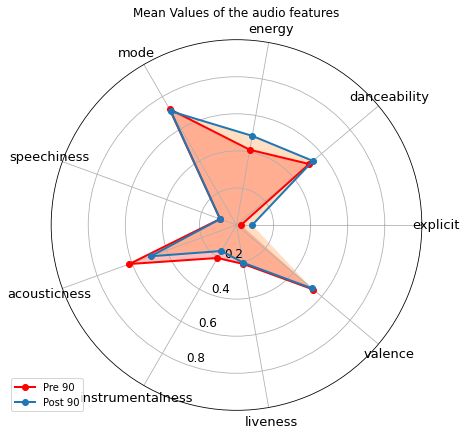

In [61]:
df_pre90 = df_pre90[['explicit', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence' ]]
df_post_90 = df_post_90[['explicit', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence' ]]

labels = list(df_pre90)[:]
stats = df_pre90.mean().tolist()
stats2 = df_post_90.mean().tolist()

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "Pre 90", color= 'red')
ax.fill(angles, stats, alpha=0.25, facecolor='red')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "Post 90")
ax.fill(angles, stats2, alpha=0.25)
ax.set_title('Mean Values of the audio features')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

 **Compare before 90 (pre90) and after 90 (post90)**:
 - pre90 had more **acousticsness** and **instrumentalness** than post90, as explain in the above, this cause by tendency to use more electrical and cyber instruments, and the audience also welcome new instruments sound in music.
 - **explicit** from 90 to now is highers, because music from then reflect more about real life and also for lyric with come for more sensitive/rudeness words in lyric
 - **Energy** from 90 to now is highers, because music have tend to become more louder, more vibrant with the need of man to listen music for relax and motivate their mood.
 - other is nearly the same


# **Question 7**: 
# How do you become a famous song writer?

In [62]:
# Get the weights from lm_model
df_weight = pd.DataFrame({'variables' :X_train.columns, 'weights' :lm_model.coef_}).sort_values(by='weights').set_index('variables')
display(df_weight)

,weights
variables,
speechiness,-11.890593
valence,-9.913032
acousticness,-9.562296
liveness,-4.889798
instrumentalness,-1.845670
mode_1,-0.469833
key_3,-0.454944
key_2,-0.394916
key_9,-0.351914


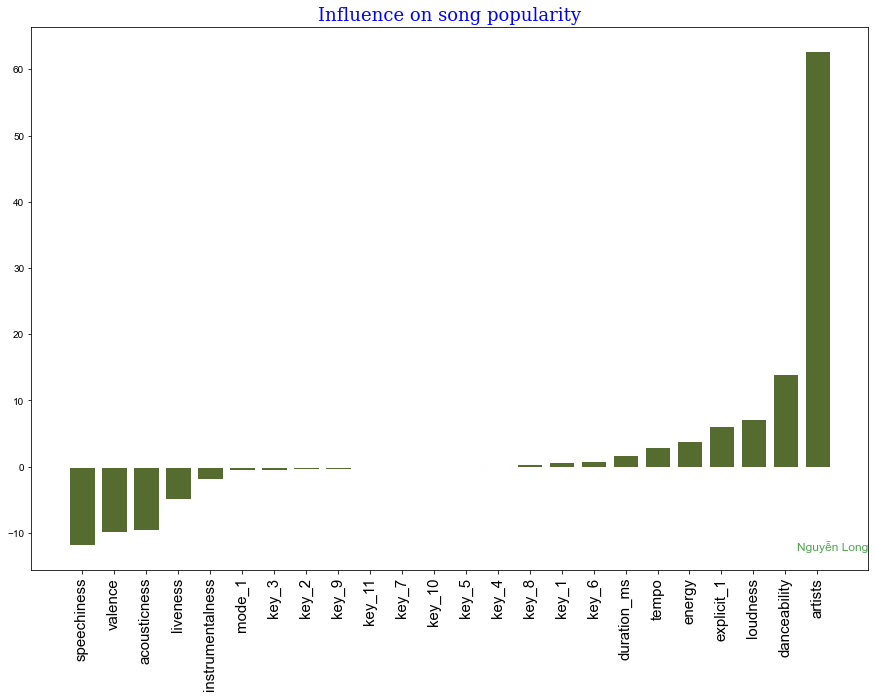

In [64]:
plot_bar(df_weight['weights'], df_weight.index,color = 'darkolivegreen',
         title = 'Influence on song popularity', color_title= 'blue', x_rotate = 180,fig_dims = (15,10))

**Conclusion**: 
So, in order to write popular songs, we should:
- Famous: It is easier to produce a popular song if the artist is already famous.
- Produce/write energetic, loud and danceable songs!
- Do not write purely instrumental songs and do not intensify a strong acoustic environment within your song!

# **Question 8**: 
# Which actual top artists write/have the most popular songs?

In [65]:
# Who are the top 10 artists between 1921-2020?
# As a second order popularity condition, artists must have more than 250 songs on Spotify
data_topArtists = df.sort_values(by='popularity', ascending=False)
printmd('***Most popular songs:***')
data_topArtists.loc[:,'artist'] = data_topArtists['artists'].map(lambda x: x.replace('[', '').replace(']', '').replace('\'', ''))

display(data_topArtists[['name', 'artist', 'popularity', 'year']].head(10))

data_topArtists['top_artist'] = data_topArtists['artists'].map(data_topArtists['artists'].value_counts()>250)
top_art  = data_topArtists.groupby(['artist', 'top_artist'])['popularity'].mean().sort_values(ascending=False).reset_index(1)
data_to_plot = top_art.loc[top_art['top_artist'] == True,['popularity']].head(20)
data_to_plot


***Most popular songs:***

,name,artist,popularity,year
release_date,,,,
2020-03-20,Blinding Lights,The Weeknd,100,2020
2020-04-17,ROCKSTAR (feat. Roddy Ricch),"DaBaby, Roddy Ricch",99,2020
2020-02-08,death bed (coffee for your head) (feat. beabad...,"Powfu, beabadoobee",97,2020
2020-04-24,THE SCOTTS,"THE SCOTTS, Travis Scott, Kid Cudi",96,2020
2019-11-26,ily (i love you baby) (feat. Emilee),"Surf Mesa, Emilee",95,2019
2020-04-03,Toosie Slide,Drake,95,2020
2019-12-06,The Box,Roddy Ricch,95,2019
2019-11-15,Supalonely,"BENEE, Gus Dapperton",95,2019
2020-04-21,Party Girl,StaySolidRocky,94,2020


,popularity
artist,
The Beatles,48.075610
Bob Marley & The Wailers,43.098976
Led Zeppelin,41.417160
Elton John,37.444853
Fleetwood Mac,34.874372
The Rolling Stones,34.511719
Stevie Wonder,34.088123
Elvis Presley,33.489754
Queen,32.399061


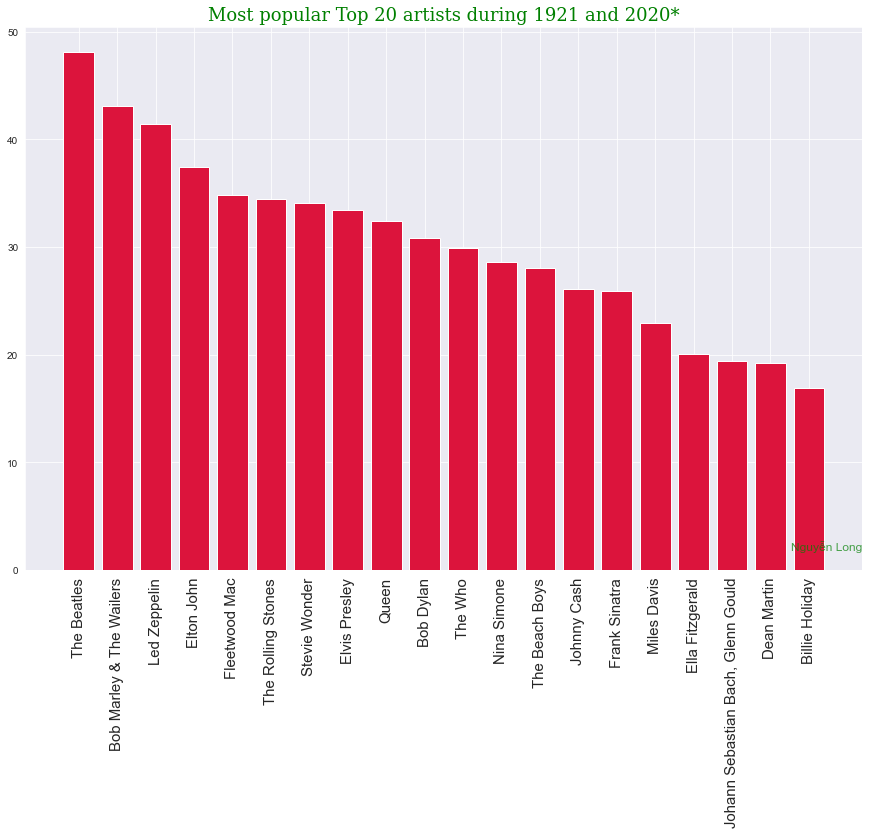

*artists with more than 200 songs on Spotify

In [66]:
plot_bar(data_to_plot['popularity'], data_to_plot.index, color = 'crimson', fig_dims = (15,10),
         title ='Most popular Top 20 artists during 1921 and 2020*',
         color_title='green',x_rotate = 90)

printmd('*artists with more than 200 songs on Spotify')

# **Question 9**: 
# In order to write a popular song, is the key and mode important?
# Does popularity depend on the categorical values of key and/or mode?

In [67]:
# Dictionary of musical notes for backward Key Note Translation
key = {0: 'C', 1:'C#', 2:'D', 3:'D#', 4:'E', 5:'F', 6:'F#', 7:'G', 8:'G#', 9:'A', 10:'A#', 11:'B'}
key_df=pd.DataFrame(df["key"].value_counts())

In [68]:
key_df.head()

,key
0,21499
7,20757
2,18821
9,17628
5,16336


In [69]:
key_df["key names"]= key_df.index.to_series().map(key)
key_df

,key,key names
0,21499,C
7,20757,G
2,18821,D
9,17628,A
5,16336,F
4,12921,E
1,12816,C#
10,12056,A#
8,10711,G#
11,10593,B


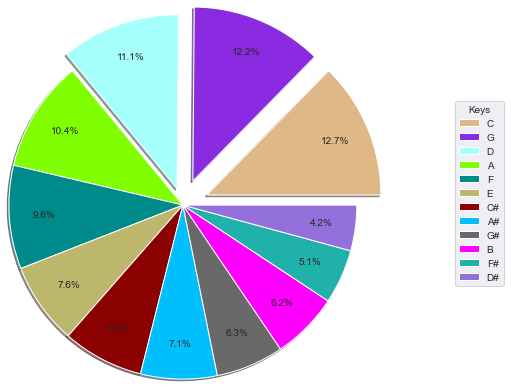

In [70]:
colors=["#DEB887","#8A2BE2", "#A5FFFA", "#7FFF00", "#008B8B", "#BDB76B", "#8B0000", "#00BFFF","#696969","#FF00FF","#20B2AA","#9370DB"]
plt.figure(figsize=(12,4))
key_labels=key_df["key names"].values
key_values=key_df["key"].values
plt.pie(key_values,shadow=True,pctdistance=0.8, autopct="%.1f%%",radius=2,explode=(0.3,0.3,0.2,0,0,0,0,0,0,0,0,0),center=(2,3),colors=colors)
plt.legend(labels=key_labels, bbox_to_anchor=(2,1),title="Keys")

The pie graph above shows the distribution of keys in the dataset. As can be observed, the most used keys are C, G and D. If we delve a little into the basics of music theory, we see that that the key of C has no sharps.

Scale of C -> C - D - E - F - G - A - B - C

Since this key has no sharps, it is easiest scale to play on an instrument. Hence, it is the most used key in music.

The same can be said about the key of G. The key of G has only one sharp.

Scale of G -> G - A - B - C - D - E - F# - G

The next 2 most used keys are D and A, and they have 2 and 3 sharps respectively. Hence we see that the usage of the different keys has a dependance on the ease of the key.

The modes can be divided into two categories, Major and Minor.

The sound of Major is usually associated with happiness and blissfulness, while the sound of minor is usually associated with sadness or gloominess.

In [71]:
mode={0:"Minor", 1:"Major"}
mode_df=pd.DataFrame(df["mode"].value_counts())
mode_df["Mode names"]=mode_df.index.to_series().map(mode)
mode_df

,mode,Mode names
1,120390,Major
0,49519,Minor


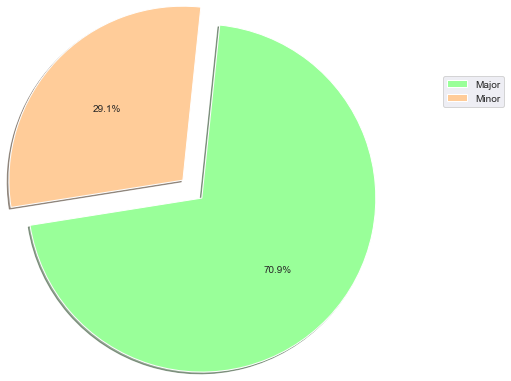

In [72]:
plt.figure(figsize=(10,4))
colors = ['#99ff99','#ffcc99']
mode_labels=mode_df["Mode names"].values
mode_values=mode_df["mode"].values
plt.pie(mode_values,colors = colors , shadow=True,autopct="%.1f%%",radius=2,explode=(0.3,0),center=(2,1), startangle=189)
plt.legend(labels=mode_labels, bbox_to_anchor=(2,1))

70% composer choose Major Chord for their tracks, major chords tend to sound brighter and minor chords sound darker.
So their song will be happer, whereas minor chord tracks have tend to sad, lonely.
It also mean 70% tracks of dataset have tend to sound happy and bright.

# **Question 10**:
# Recommend Song for user when input artist, songs 

This question I use the 2nd dataset.
This 2nd dataset (**Spotify_220ksong_by_Genre**) has 232725 observations, 18 columns (12 numerical and 6 categorical/dummy).
All the colum is the same as dataset 1, only different that it has extra column "genre" to classify song.
This dataset is more situable for this question
Source: https://www.kaggle.com/varun3garg/spotify-top-5-eda

In [73]:
data = pd.read_csv("Spotify_220ksong_by_Genre.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4-Apr,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4-Apr,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,4-May,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4-Apr,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4-Apr,0.390


In [74]:
indx = data[['track_name', 'artist_name']]
attributes = data.drop(['track_id', 'time_signature','track_name', 'artist_name', 'key'], axis = 1)
attributes.head()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,Major,0.0525,166.969,0.814
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,Minor,0.0868,174.003,0.816
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,Minor,0.0362,99.488,0.368
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,Major,0.0395,171.758,0.227
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,Major,0.0456,140.576,0.390


In [75]:
ordinal_encoder = OrdinalEncoder()
object_cols = ['mode']
attributes[object_cols] = ordinal_encoder.fit_transform(attributes[object_cols])

attributes = pd.get_dummies(attributes)
attributes.insert(loc=0, column='track_name', value=indx.track_name)
attributes.insert(loc=1, column = 'artist_name', value = indx.artist_name)

In [76]:
genres_names = ['genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues',
       "genre_Children's Music", "genre_Children’s Music", 'genre_Classical',
       'genre_Comedy', 'genre_Country', 'genre_Dance', 'genre_Electronic',
       'genre_Folk', 'genre_Hip-Hop', 'genre_Indie', 'genre_Jazz',
       'genre_Movie', 'genre_Opera', 'genre_Pop', 'genre_R&B', 'genre_Rap',
       'genre_Reggae', 'genre_Reggaeton', 'genre_Rock', 'genre_Ska',
       'genre_Soul', 'genre_Soundtrack', 'genre_World']

In [77]:
genres = attributes.groupby(['track_name', 'artist_name'])[genres_names].sum()

column_names = ['track_name', 'artist_name']
for i in genres_names:
    column_names.append(i)

genres.reset_index(inplace=True)
genres.columns = column_names

attributes = attributes.drop(genres_names, axis = 1)

atts_cols = attributes.drop(['track_name', 'artist_name'], axis = 1).columns
scaler = StandardScaler()
attributes[atts_cols] = scaler.fit_transform(attributes[atts_cols])

songs = pd.merge(genres, attributes, how = 'inner', on = ['track_name', "artist_name"])
songs = songs.drop_duplicates(['track_name', 'artist_name']).reset_index(drop = True)

In [78]:
DF = pd.DataFrame(songs.drop(['track_name', 'artist_name'], axis = 1))
kmeans = KMeans(n_clusters=17)
songs['Cluster'] = kmeans.fit_predict(DF)

In [94]:
printmd('Test find similar song to Our Song - artist: Taylor Swift')
dists = find_similar('Our Song', 'Taylor Swift', songs)
dists

Test find similar song to Our Song - artist: Taylor Swift

,track_name,artist_name,Cluster,result
0,Wide Awake,Katy Perry,5,0.975746
1,FU,Miley Cyrus,5,0.967278
2,Nobody Gotta Know,Why Don't We,5,0.967194
3,Cuz I Love You,Lizzo,5,0.965656


In [96]:
printmd('A playlist songs similar to song: Baby - artist: Justin Bieber')
playlist_song('Baby', "Justin Bieber",  songs, 10)

A playlist songs similar to song: Baby - artist: Justin Bieber

Playlist based on "Baby" by Justin Bieber

Pussy Is God - King Princess
Vente Pa' Ca - Ricky Martin
The Heart Wants What It Wants - Selena Gomez
SUBEME LA RADIO - Enrique Iglesias
Come & Get It - Selena Gomez
Steal My Girl - One Direction
El Clavo - Prince Royce
Problem - Ariana Grande
EL BAÑO - Enrique Iglesias
